# Photo-z data AugMent (PAM)

#### Setup:

Run `source setup.sh` from `bash` command line in kernel in order to setup paths for code.

## Create train/test catalogs

In [1]:
import os
import numpy as np
from create_cats import create_cats
%load_ext autoreload
%autoreload 2

### Create catalogs

In [2]:
# Catalog columns
names = ['index', 'redshift', 'u', 'g', 'r', 'i', 'z', 'y', 'g_abs', 'r_abs']

In [3]:
# Point to catalog
cat_name = 'Euclid_trim_27p5_3p5_short.dat'
filename = os.path.join(os.environ['PZ_CAT_FOLDER'], cat_name)
cc = create_cats(filename, names)

Training set size: 500000. Test set size: 2000000.


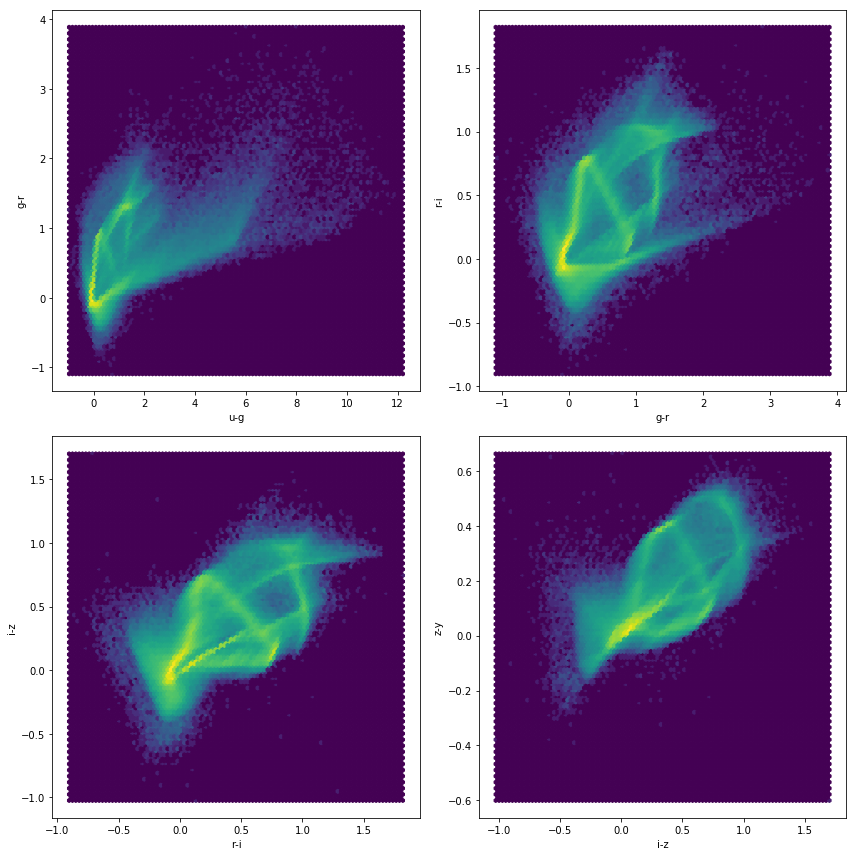

In [4]:
# Create a base train/test catalog with 500,000 objects in training set
# and remaining in test set
cc.create_base_cats('full', 500000, out_dir='../data', random_state=2136)

Color group histogram: 
(array([ 89042, 336619,  22396,  51943]), array([0.  , 0.75, 1.5 , 2.25, 3.  ]))
Removing Color Group 0
Training set size: 410958. Test set size: 2000000.


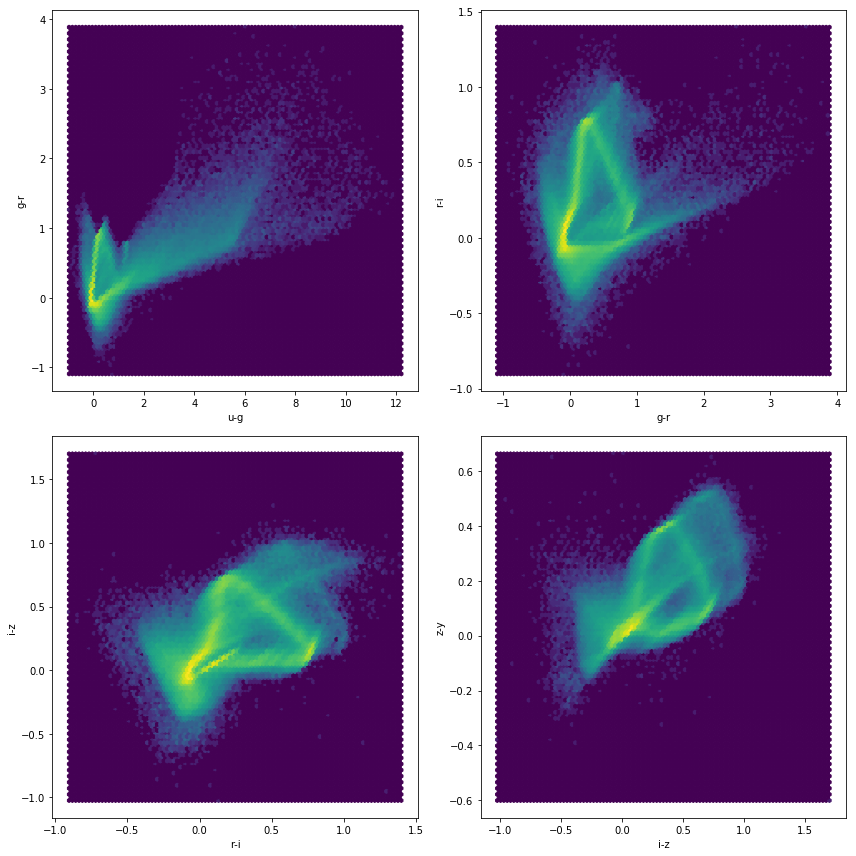

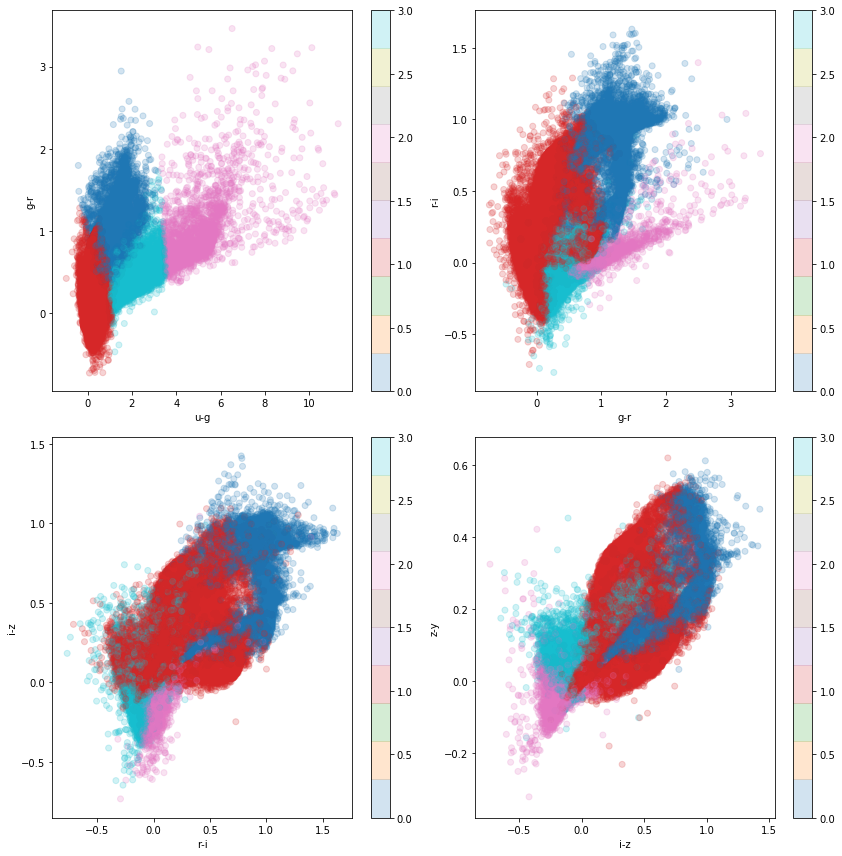

In [5]:
# Group color cut
cc.create_color_group_cats('4_group_color_cut_0', 500000, 4, choose_out=0, out_dir='../data', random_state=2136)

### Create combined catalog

In [5]:
import pandas as pd
from photoz_nn import photoz_nn, Net
import torch

In [6]:
rest_frame_train_cat = pd.read_csv('../data/rest_frame_only_train.csv')
rest_frame_templates_cat = pd.read_csv('../data/rest_frame_templates_train.csv')
color_cut_train_cat = pd.read_csv('../data/train_cat_4_group_color_cut_0.dat')

In [7]:
combined_cat = pd.concat([rest_frame_train_cat, color_cut_train_cat])

In [8]:
combined_template_cat = pd.concat([rest_frame_templates_cat, color_cut_train_cat])

In [9]:
rest_frame_templates_cat.head(), color_cut_train_cat.head()

(   redshift          u          g          r          i          z          y
 0       0.0 -10.982393 -10.937266 -10.797457 -10.672042 -10.580262 -10.537693
 1       0.0  -8.745037  -9.452467  -9.882239 -10.164492 -10.278910 -10.406951
 2       0.0  -7.824727  -8.988688  -9.585008  -9.954121 -10.124608 -10.344787
 3       0.0  -8.694117  -9.463771  -9.835809 -10.048327 -10.119445 -10.303556
 4       0.0  -8.203827  -9.106192  -9.498884  -9.715543  -9.736192  -9.967468,
    redshift        u        g        r        i        z        y
 0  0.708277  27.5278  27.4826  27.0514  26.4112  26.3398  26.3135
 1  3.297912  31.7478  26.6329  25.4428  25.3954  25.7079  25.7969
 2  2.175147  26.4805  26.1697  26.2675  26.3462  26.2657  26.2155
 3  2.100762  30.7369  28.4791  27.5407  27.2548  26.6204  26.2846
 4  2.097417  26.6531  26.4531  26.5904  26.6739  26.6440  26.6244)

In [89]:
combined_cat.to_csv('../data/train_cat_combined.dat', index=False)

In [256]:
combined_template_cat.to_csv('../data/train_cat_combined_templates.dat', index=False)

## Train networks

In [34]:
for train_suffix, test_suffix in zip(['full'],#, '4_group_color_cut_0', 'combined'],
                                     ['full']):#, 'full', 'full']):
    
    print(train_suffix)
    n_epochs = 500
    pz_nn = photoz_nn(seed=1446)

    train_filename = '../data/train_cat_%s.dat' % train_suffix
    train_colors, train_specz = pz_nn.load_catalog(train_filename)
    test_filename = '../data/test_cat_%s.dat' % test_suffix
    test_colors, test_specz = pz_nn.load_catalog(test_filename)

    train_len = len(train_colors)
    test_len = len(test_colors)

    #net = pz_nn.train_model(train_colors, train_specz, n_epochs)
    net = Net(5, 20, 1)
    net.load_state_dict(torch.load('../data/pz_network_%s.pt' % train_suffix))

    train_colors, train_specz = pz_nn.load_catalog(train_filename)
    train_photoz = pz_nn.run_model(net, train_colors)
    test_photoz = pz_nn.run_model(net, test_colors)

    #pz_nn.save_model(net, '../data/pz_network_%s.pt' % train_suffix)

    train_results = {'true_z':train_specz.reshape(train_len),
                     'photo_z': train_photoz.reshape(train_len)}
    train_results_df = pd.DataFrame.from_dict(data=train_results)
    test_results = {'true_z':test_specz.reshape(test_len),
                    'photo_z': test_photoz.reshape(test_len)}
    test_results_df = pd.DataFrame.from_dict(data=test_results)
    train_results_df.to_csv('../data/train_results_%s.csv' % train_suffix, index=False)
    test_results_df.to_csv('../data/test_results_%s.csv' % train_suffix, index=False)

full
Catalog size: 500000.
Catalog size: 2000000.


TypeError: super(type, obj): obj must be an instance or subtype of type

## Plot results

In [4]:
from plot_pz_nn import plot_pz_nn

In [5]:
plot_pz = plot_pz_nn()

In [6]:
# Load results into dictionary
import pandas as pd
train_results_dict = {}
test_results_dict = {}

#for cat_suffix in ['full', 'brown_full', '4_group_color_cut_0', 'combined']:
for cat_suffix in ['full', '4_group_color_cut_0', 'combined_templates']:#, 'combined_templates']:
    train_results_dict[cat_suffix] = pd.read_csv('../data/train_results_%s.csv' % cat_suffix)
    test_results_dict[cat_suffix] = pd.read_csv('../data/test_results_%s.csv' % cat_suffix)

### Plot single results

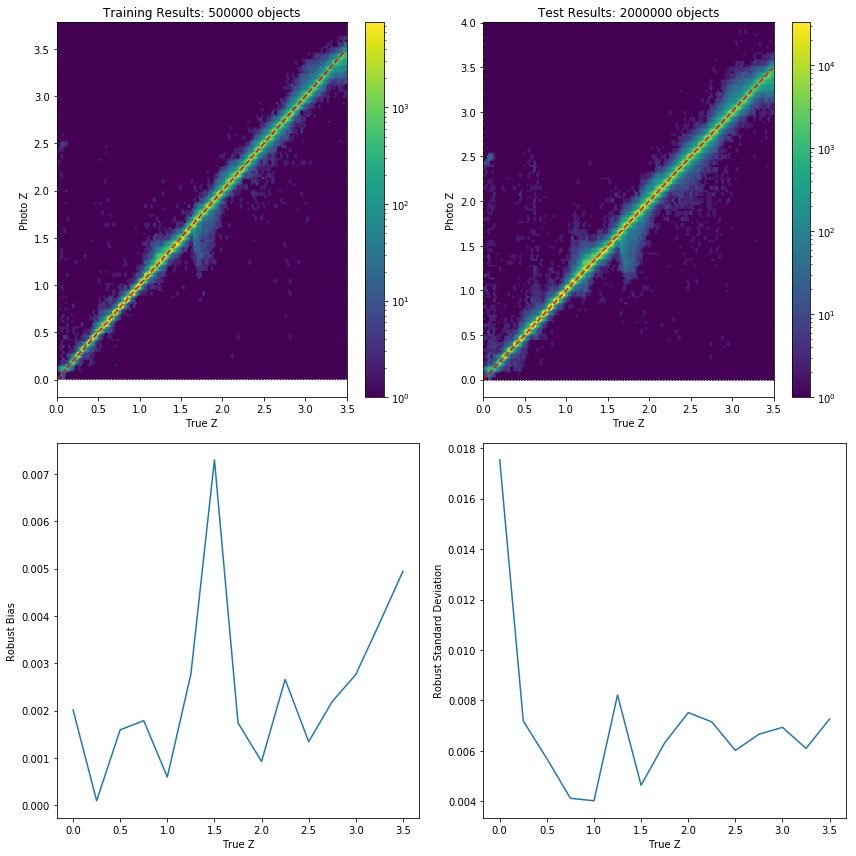

In [7]:
# full
cat_string = 'full'
plot_pz.plot_single_results(train_results_dict[cat_string], test_results_dict[cat_string],
                            '../data/%s_results.pdf' % cat_string)

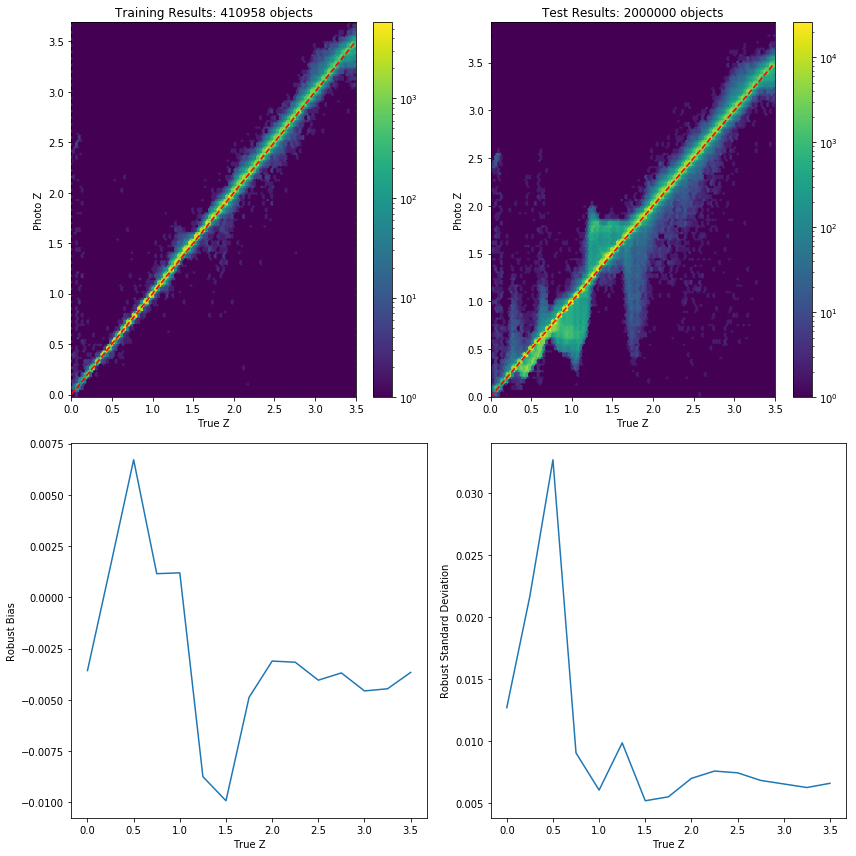

In [8]:
# color cut 0
cat_string = '4_group_color_cut_0'
plot_pz.plot_single_results(train_results_dict[cat_string], test_results_dict[cat_string],
                            '../data/%s_results.pdf' % cat_string)

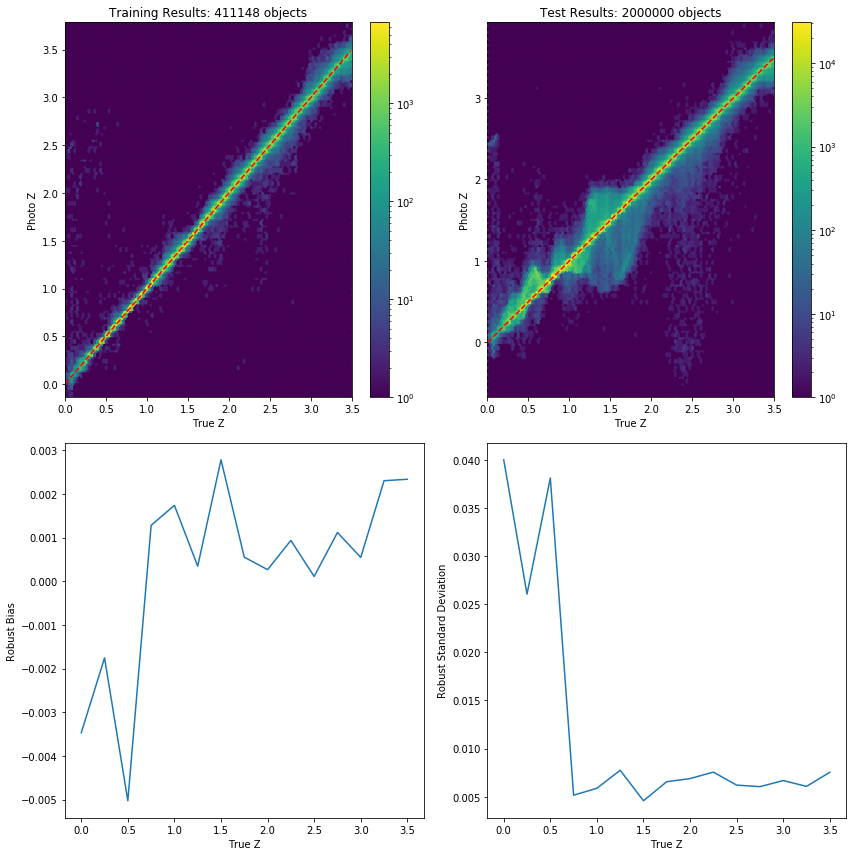

In [9]:
# combined from rest frame template mismatch
cat_string = 'combined_templates'
plot_pz.plot_single_results(train_results_dict[cat_string], test_results_dict[cat_string],
                            '../data/%s_results.pdf' % cat_string)

### Compare Results

In [71]:
from calc_metrics import point_metrics

In [235]:
pm = point_metrics()

In [244]:
ct_std = pm.photo_z_robust_stdev(test_results_dict['combined_templates']['photo_z'],
                        test_results_dict['combined_templates']['true_z'], 3.5, 10)

In [245]:
g4_std = pm.photo_z_robust_stdev(test_results_dict['4_group_color_cut_0']['photo_z'],
                        test_results_dict['4_group_color_cut_0']['true_z'], 3.5, 10)

In [238]:
ct_std / g4_std

array([1.12669001, 0.47039357, 0.8287892 , 1.02734189, 1.05015899,
       1.00081582, 0.90684734, 1.0038766 , 1.05766252, 0.83883136])

In [248]:
ct_std g4_std

array([ 2.69841071e-03, -1.23691165e-02, -2.47470669e-03,  2.63120722e-04,
        3.57555865e-04,  6.98827506e-06, -8.07178861e-04,  3.13736872e-05,
        3.91858668e-04, -1.71122146e-03])

In [239]:
np.mean(ct_std / g4_std)

0.9311407282454504

In [240]:
ct_std = pm.photo_z_stdev(test_results_dict['combined_templates']['photo_z'],
                        test_results_dict['combined_templates']['true_z'], 3.5, 15)

In [241]:
g4_std = pm.photo_z_stdev(test_results_dict['4_group_color_cut_0']['photo_z'],
                        test_results_dict['4_group_color_cut_0']['true_z'], 3.5, 15)

In [242]:
ct_std/g4_std

array([0.95836934, 0.66275496, 0.36885342, 0.61635357, 0.9453019 ,
       1.59282108, 1.42542028, 0.95792397, 0.9143505 , 0.96233648,
       1.16968927, 1.16854174, 1.1324638 , 0.98693196, 0.94475188])

In [243]:
np.mean(ct_std / g4_std)

0.9871242751771169

In [227]:
ct_bias = pm.photo_z_robust_bias(test_results_dict['combined_templates']['photo_z'],
                                 test_results_dict['combined_templates']['true_z'], 3.5, 15)

In [228]:
g4_bias = pm.photo_z_robust_bias(test_results_dict['4_group_color_cut_0']['photo_z'],
                        test_results_dict['4_group_color_cut_0']['true_z'], 3.5, 15)

In [229]:
np.abs(ct_bias) / np.abs(g4_bias)

array([ 2.02362758,  2.11502456,  0.13536188,  0.38274508,  1.25880594,
        0.86877187,  0.38031013,  0.18731971,  0.60292268,  0.91726892,
        2.03445807,  2.15791247,  3.91832091, 45.50051708,  4.45043526])

In [230]:
ct_bias = pm.photo_z_bias(test_results_dict['combined_templates']['photo_z'],
                                 test_results_dict['combined_templates']['true_z'], 3.5, 15)

In [231]:
g4_bias = pm.photo_z_bias(test_results_dict['4_group_color_cut_0']['photo_z'],
                        test_results_dict['4_group_color_cut_0']['true_z'], 3.5, 15)

In [232]:
np.abs(ct_bias) / np.abs(g4_bias)

array([9.26806634e-01, 4.61608538e-01, 2.24394663e-02, 4.13698755e-01,
       1.22765534e+00, 1.55555193e+00, 1.46233571e+00, 8.41217997e-01,
       1.47895044e+00, 1.25895210e+00, 3.07278752e+00, 8.22158672e+00,
       2.11070062e+00, 1.77631428e+00, 2.47462276e+01])

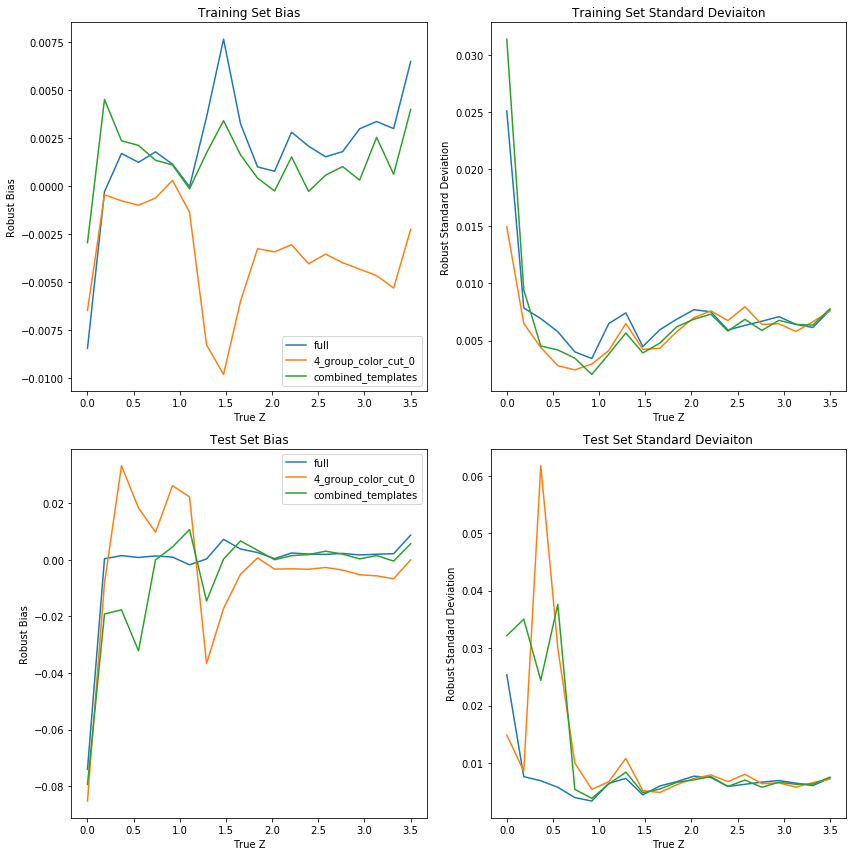

In [10]:
plot_pz.plot_multiple_results(list(train_results_dict.values()),
                              list(test_results_dict.values()),
                              list(train_results_dict.keys()),
                              '../data/compare_all.pdf', n_bins=20)

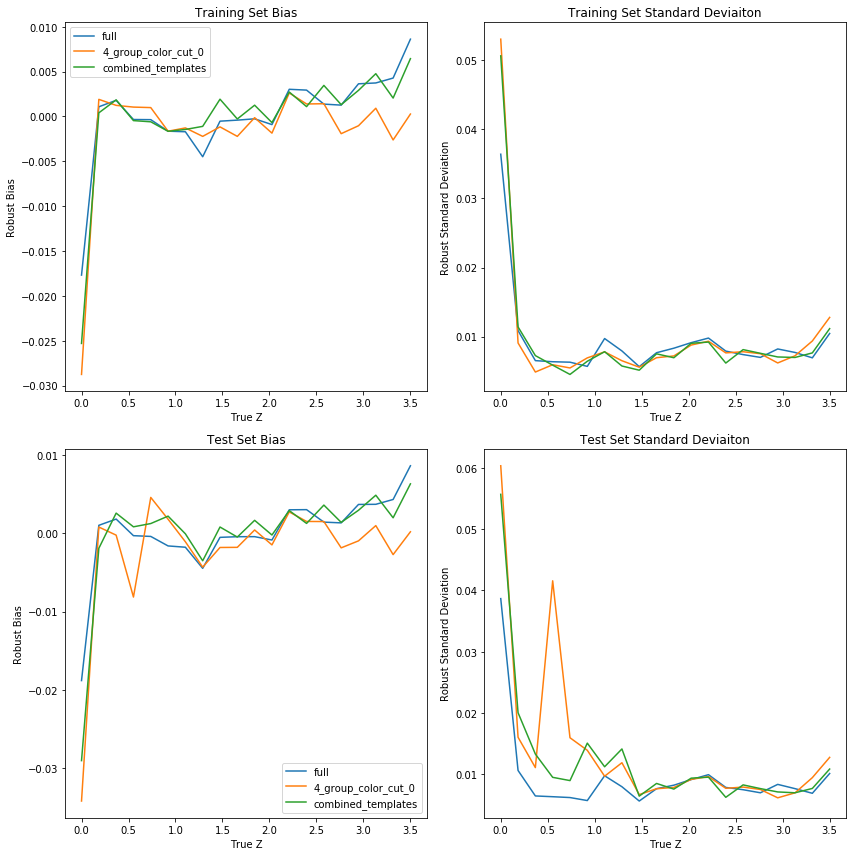

In [253]:
plot_pz.plot_multiple_results(list(train_results_dict.values()),
                              list(test_results_dict.values()),
                              list(train_results_dict.keys()),
                              '../data/compare_all.pdf', n_bins=20)

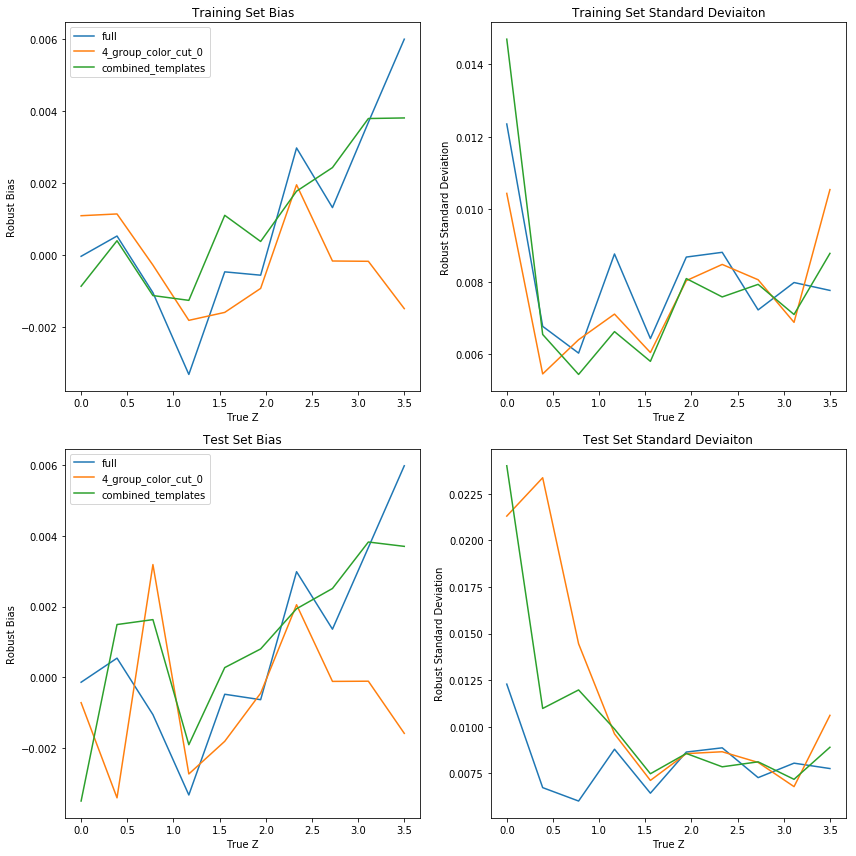

In [254]:
plot_pz.plot_multiple_results(list(train_results_dict.values()),
                              list(test_results_dict.values()),
                              list(train_results_dict.keys()),
                              '../data/compare_all.pdf', n_bins=10)

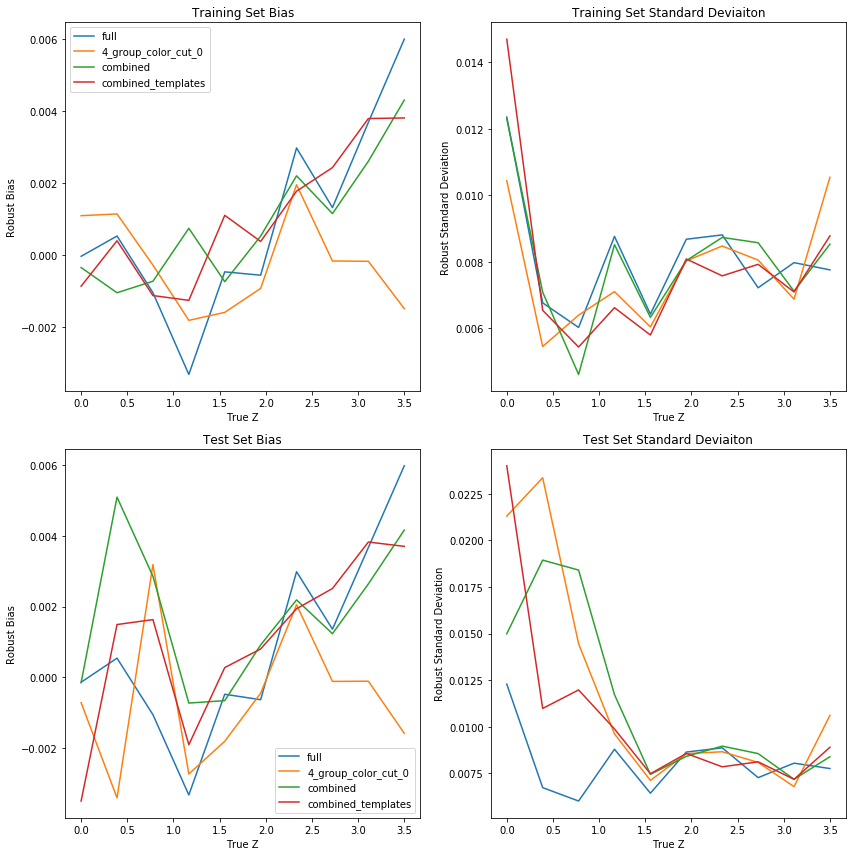

In [233]:
plot_pz.plot_multiple_results(list(train_results_dict.values()),
                              list(test_results_dict.values()),
                              list(train_results_dict.keys()),
                              '../data/compare_all.pdf', n_bins=10)

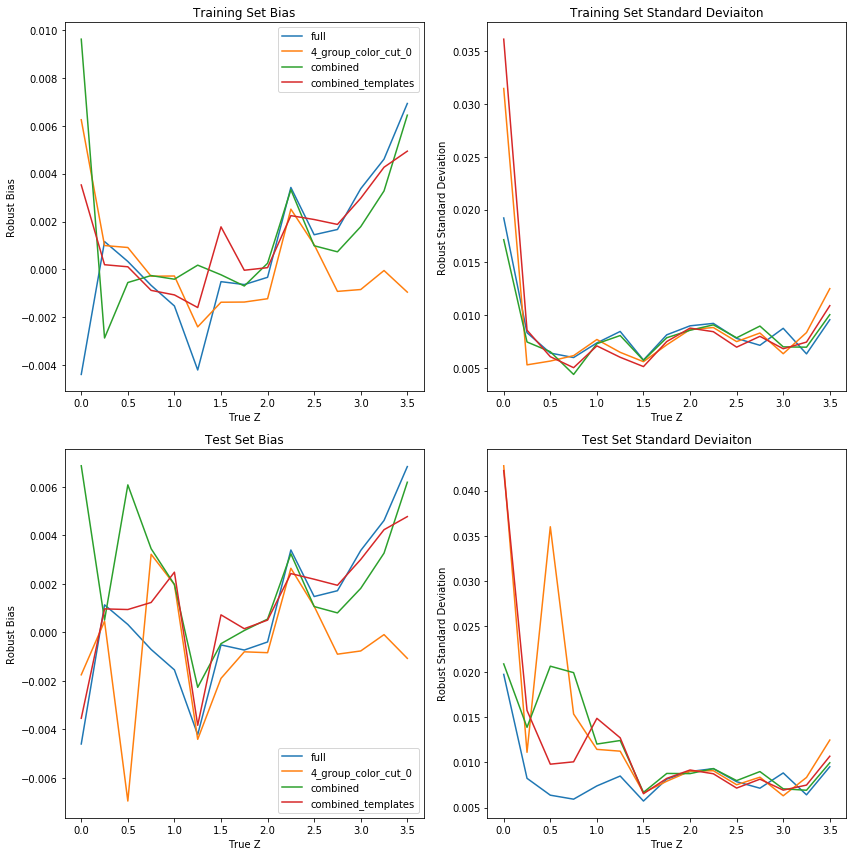

In [234]:
plot_pz.plot_multiple_results(list(train_results_dict.values()),
                              list(test_results_dict.values()),
                              list(train_results_dict.keys()),
                              '../data/compare_all.pdf')

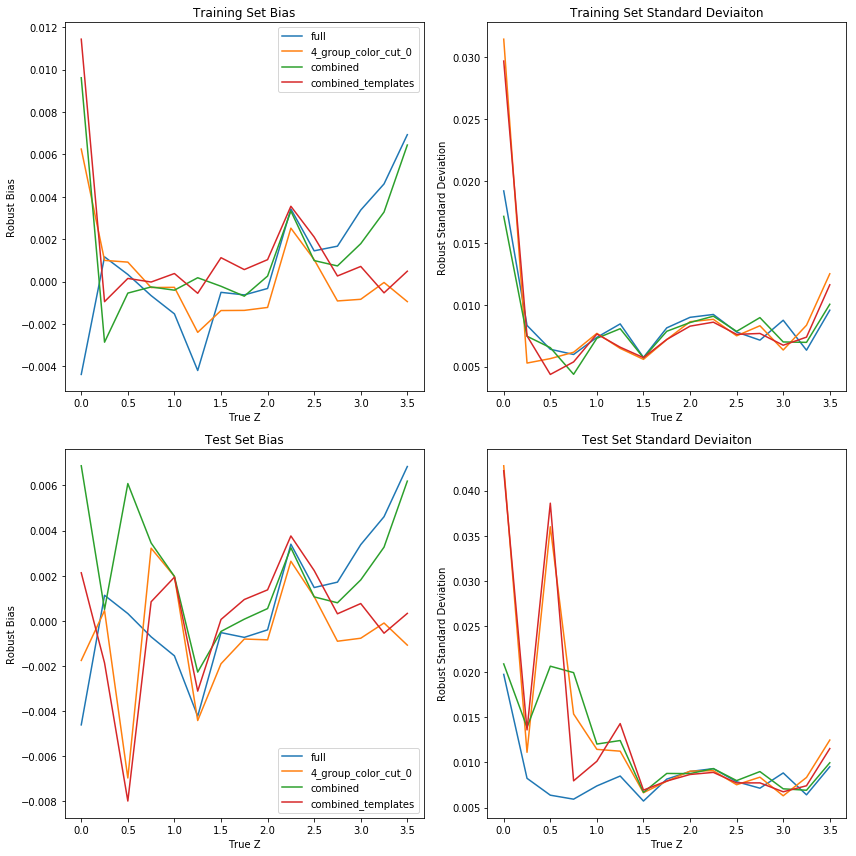

In [147]:
plot_pz.plot_multiple_results(list(train_results_dict.values()),
                              list(test_results_dict.values()),
                              list(train_results_dict.keys()),
                              '../data/compare_all.pdf')

In [161]:
# Load results into dictionary
import pandas as pd
train_results_dict = {}
test_results_dict = {}

#for cat_suffix in ['full', 'brown_full', '4_group_color_cut_0', 'combined']:
for cat_suffix in ['full', '4_group_color_cut_0', 'combined', #'combined_esp',
                   'combined_cut']:#, 
                   #'combined_cut_esp']:#, 'brown_full', 'brown_esp']:
    train_results_dict[cat_suffix] = pd.read_csv('../data/train_results_%s.csv' % cat_suffix)
    test_results_dict[cat_suffix] = pd.read_csv('../data/test_results_%s.csv' % cat_suffix)

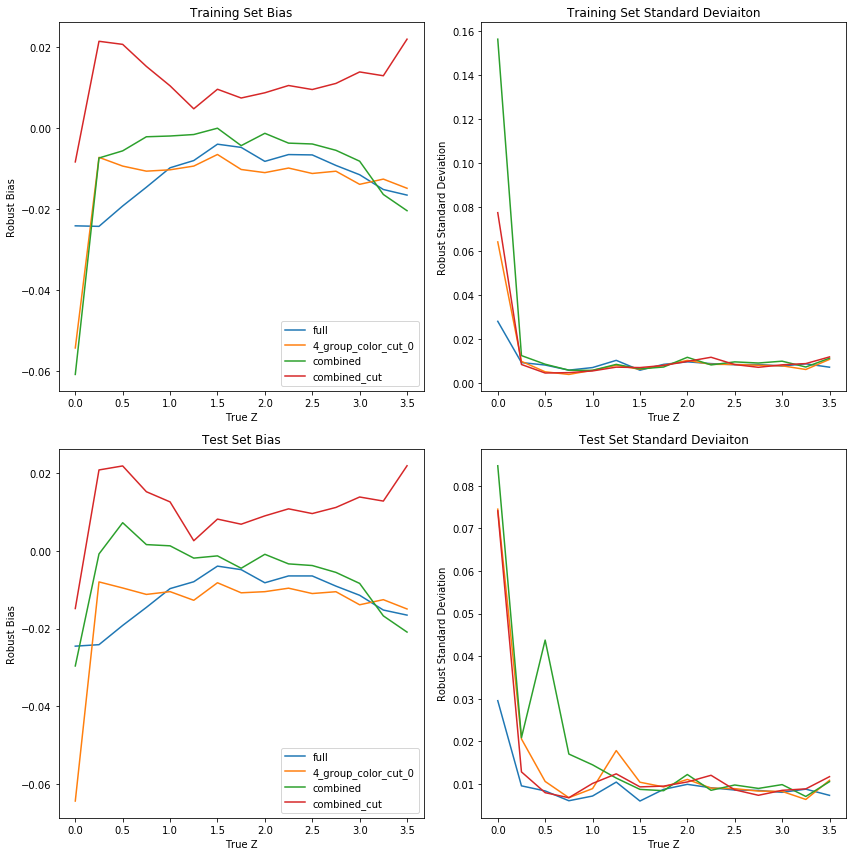

In [162]:
plot_pz.plot_multiple_results(list(train_results_dict.values()),
                              list(test_results_dict.values()),
                              list(train_results_dict.keys()),
                              '../data/compare_all.pdf')

In [153]:
# Load results into dictionary
import pandas as pd
train_results_dict = {}
test_results_dict = {}

#for cat_suffix in ['full', 'brown_full', '4_group_color_cut_0', 'combined']:
for cat_suffix in ['full', '4_group_color_cut_0', 'combined_cut', 'combined_cut_esp']:#, 'brown_full', 'brown_esp']:
    train_results_dict[cat_suffix] = pd.read_csv('../data/train_results_%s.csv' % cat_suffix)
    test_results_dict[cat_suffix] = pd.read_csv('../data/test_results_%s.csv' % cat_suffix)

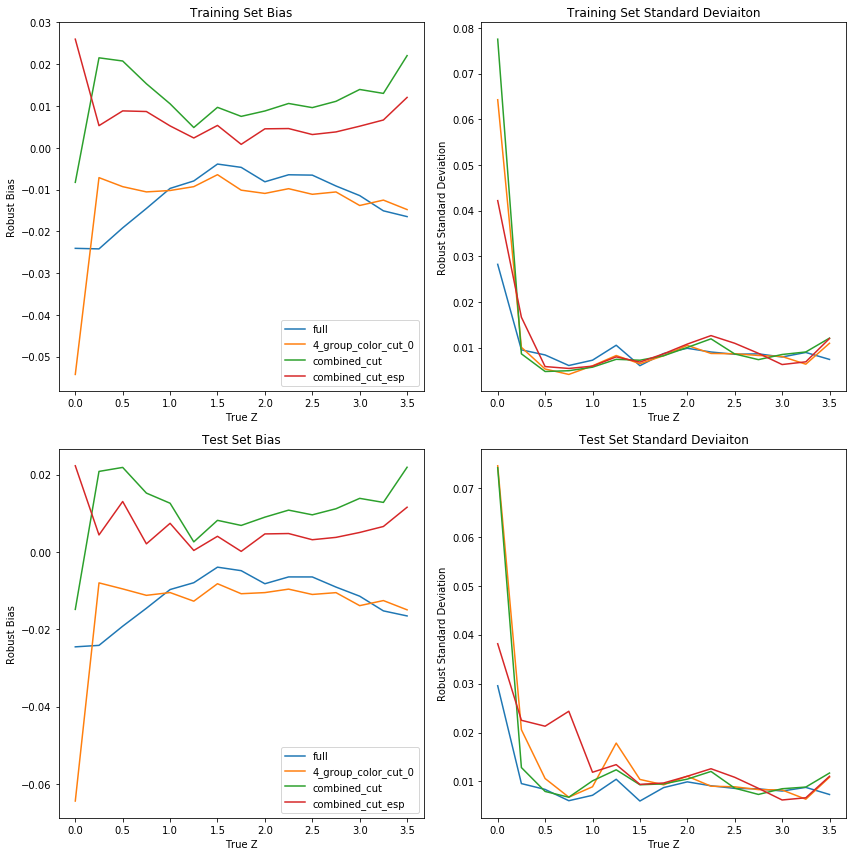

In [154]:
plot_pz.plot_multiple_results(list(train_results_dict.values()),
                              list(test_results_dict.values()),
                              list(train_results_dict.keys()),
                              '../data/compare_all.pdf')

In [155]:
# Load results into dictionary
import pandas as pd
train_results_dict = {}
test_results_dict = {}

#for cat_suffix in ['full', 'brown_full', '4_group_color_cut_0', 'combined']:
for cat_suffix in ['full', '4_group_color_cut_0', 'combined', 
                   'combined_esp', 'combined_cut', 'combined_cut_esp',
                   'brown_full', 'brown_esp']:
    train_results_dict[cat_suffix] = pd.read_csv('../data/train_results_%s.csv' % cat_suffix)
    test_results_dict[cat_suffix] = pd.read_csv('../data/test_results_%s.csv' % cat_suffix)

#### Find regions where results are missing and compare

In [11]:
# Load color labels
color_labels = np.genfromtxt('../data/test_labels_4_group_color_cut_0.dat')
test_full_df_color_cut = test_results_dict['full'].iloc[np.where(color_labels == 0.)].reset_index(drop=True)
test_colors_df = test_results_dict['4_group_color_cut_0'].iloc[np.where(color_labels == 0.)].reset_index(drop=True)
#test_brown_df = test_results_dict['brown_full'].iloc[np.where(color_labels == 0.)].reset_index(drop=True)
test_combined_df = test_results_dict['combined_templates'].iloc[np.where(color_labels == 0.)].reset_index(drop=True)
#test_combined_cut_df = test_results_dict['combined_cut'].iloc[np.where(color_labels == 0.)].reset_index(drop=True)
#test_combined_cut_esp_df = test_results_dict['combined_cut_esp'].iloc[np.where(color_labels == 0.)].reset_index(drop=True)
#test_combined_esp_df = test_results_dict['combined_esp'].iloc[np.where(color_labels == 0.)].reset_index(drop=True)
#test_brown_esp_df = test_results_dict['brown_esp'].iloc[np.where(color_labels == 0.)].reset_index(drop=True)

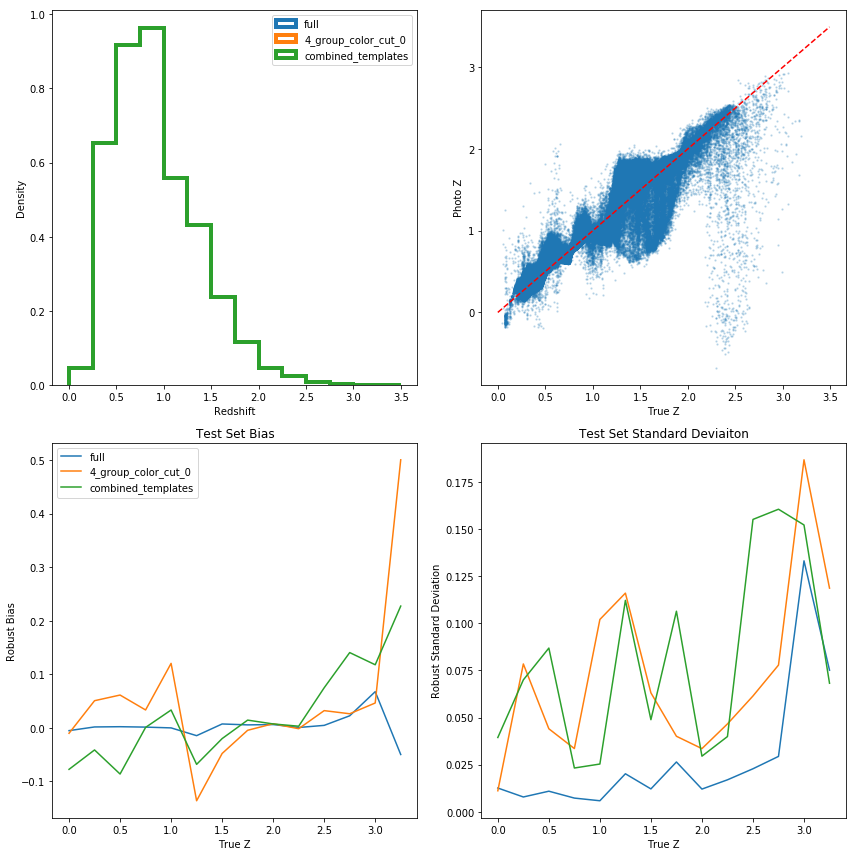

In [12]:
plot_pz.plot_cut_results([test_full_df_color_cut, test_colors_df,
                          test_combined_df],
                         ['full', '4_group_color_cut_0', 'combined_templates'],
                         '../data/compare_color_cut_0.pdf',  scatter_index=2)